# The spelled-out intro to language modeling: building makemore

Following: https://www.youtube.com/watch?v=PaCmpygFfXo&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=2

In [2]:
from pathlib import Path
from collections import defaultdict

In [3]:
data = Path('../data')

# Exploring bigrams (0:00 - 0:15:00)

Tasks done in the video:
- Load the dataset
- Explore
    - min/max length of names
    - number of names
- count all the bigrams into a dictionary
    - dedicated \<S\> and \<E\> tokens

In [4]:
names = (data/'names.txt').open().read().splitlines()
names[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [5]:
len(names)

32033

In [6]:
min(len(name) for name in names), max(len(name) for name in names)

(2, 15)

In [7]:
bigrams = defaultdict(int)
start = '<S>'
end = '<E>'

for name in names:
    name = [start] + list(name) + [end]
    for ch1,ch2 in zip(name, name[1:]):
        bigrams[(ch1,ch2)] += 1

In [8]:
sorted((bigram_tuples for bigram_tuples in bigrams.items()), key=lambda b: b[1], reverse=True)[:10]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963)]

# Bigrams into torch.Tensor ( - 00:36:00, skipping efficiency until 00:50:00)

- Goal: n*n matrix that holds the bigram count in each cell
- No more dedicated start/stopping tokens, instead use . for both
- sample from the model
    - start with the starting dot
    - choose random next character according to probabilities in that row (torch.multinomial)
    - repeat until ending-dot is reached
    - Use torch.Generator for comparability

### Bigrams to Tensor

Extracting all used characters:

In [9]:
characters = set('.')
characters = characters.union(set(''.join(names)))
characters

{'.',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

In [10]:
import torch

In [11]:
stoi = {char: i for i,char in enumerate(characters)}
itos = {i: char for char,i in stoi.items()}
stoi

{'z': 0,
 'h': 1,
 'o': 2,
 'x': 3,
 '.': 4,
 'e': 5,
 'p': 6,
 'c': 7,
 'q': 8,
 'w': 9,
 'm': 10,
 'u': 11,
 'j': 12,
 't': 13,
 'y': 14,
 'f': 15,
 'a': 16,
 'r': 17,
 'v': 18,
 'k': 19,
 's': 20,
 'b': 21,
 'g': 22,
 'd': 23,
 'i': 24,
 'n': 25,
 'l': 26}

In [12]:
bigrams = torch.zeros((len(characters), len(characters)))
start = '.'
end = '.'

for name in names:
    name = [start] + list(name) + [end]
    for ch1,ch2 in zip(name, name[1:]):
        row_index = stoi[ch1]
        col_index = stoi[ch2]
        bigrams[row_index, col_index] += 1

### Sampling

Counts for characters following the start character:

In [13]:
bigrams[stoi[start],:]

tensor([ 929.,  874.,  394.,  134.,    0., 1531.,  515., 1542.,   92.,  307.,
        2538.,   78., 2422., 1308.,  535.,  417., 4410., 1639.,  376., 2963.,
        2055., 1306.,  669., 1690.,  591., 1146., 1572.])

Drawing a sample with counts as weights:

In [14]:
next_idx = torch.multinomial(bigrams[stoi[start],:], 1, replacement=True).item()
next_char = itos[next_idx]
next_char

'e'

Repeat until the stopping token is drawn:

In [15]:
g = torch.Generator().manual_seed(2147483647)

for i in range(20):
    name = start
    while True:
        next_idx = torch.multinomial(bigrams[stoi[name[-1]],:], 1, replacement=True, generator=g).item()
        next_char = itos[next_idx]
        name += next_char

        if next_char == end:
            break


    print(name)

.kkah.
.nn.
.kaswnanilami.
.anevi.
.tr.
.joharalynn.
.bry.
.somatyey.
.myene.
.torgrranyabemulianzy.
.ciz.
.warli.
.yausoddena.
.madeiz.
.m.
.jo.
.aiakay.
.higin.
.rayanisi.
.jie.


Sanity-Check: Drawing with uniform probability

In [16]:
g = torch.Generator().manual_seed(2147483647)
weights = torch.ones(len(characters))

for i in range(20):
    name = start
    while True:
        next_idx = torch.multinomial(weights, 1, replacement=True, generator=g).item()
        next_char = itos[next_idx]
        name += next_char

        if next_char == end:
            break


    print(name)

.rgkhhniorvrtnrdblywghybufs.
.mg.
.q.
.zryfntsl.
.bruhs.
.esuapm.
.cwcgjempuvkrjdywvcqqldjbzw.
.xizxeutlbxmymfefgmgvccrvmvzxpoqhoukjafuxzisidoatuybbki.
.clpeiqdraj.
.a.
.ydlgunikrmpfvrrapiksdupfbpqgdpqtkbnnfsgxggrapxon.
.mxfbquhmuqryyarttjjhfv.
.rnzckladzljcwmwyhycllbbjkngrvbpbhdhgk.
.oydgjtvnagcvkpcakqcytdhprtkm.
.goqycgfwwciqud.
.jsv.
.udyhclnuyrgzjpks.
.rwcgyx.
.fw.
.eskbuc.


# Loss function ( - 01:03:00)

- negative Likelihood is used to measure loss (product of probabilities)
- use logs for numerical purposes (turns into the sum)

In [17]:
P = bigrams / bigrams.sum(dim=1, keepdim=True)

In [18]:
for name in names[:2]:
    name = [start] + list(name) + [end]
    log_likelihood = 0
    n = 0
    for ch1,ch2 in zip(name, name[1:]):
        row_index = stoi[ch1]
        col_index = stoi[ch2]
        prob = P[row_index, col_index]
        log = torch.log(prob)
        log_likelihood += log
        n += 1
        
        print(f'({ch1}, {ch2}): {log}')
    print(f'Neg. Log-Likelihood: {-log_likelihood}')
    print(f'Mean Neg. Log-Likelihood: {-log_likelihood / n}')
    print('')

(., e): -3.0408453941345215
(e, m): -3.2793259620666504
(m, m): -3.6772043704986572
(m, a): -0.9417552351951599
(a, .): -1.6298604011535645
Neg. Log-Likelihood: 12.568990707397461
Mean Neg. Log-Likelihood: 2.513798236846924

(., o): -4.3981709480285645
(o, l): -2.550807476043701
(l, i): -1.7277942895889282
(i, v): -4.186665058135986
(v, i): -1.0382850170135498
(i, a): -1.9795759916305542
(a, .): -1.6298604011535645
Neg. Log-Likelihood: 17.511159896850586
Mean Neg. Log-Likelihood: 2.501594305038452



In [19]:
for name in ['andrej']:
    name = [start] + list(name) + [end]
    log_likelihood = 0
    n = 0
    for ch1,ch2 in zip(name, name[1:]):
        row_index = stoi[ch1]
        col_index = stoi[ch2]
        prob = P[row_index, col_index]
        log = torch.log(prob)
        log_likelihood += log
        n += 1
        
        print(f'({ch1}, {ch2}): {log}')
    print(f'Neg. Log-Likelihood: {-log_likelihood}')
    print(f'Mean Neg. Log-Likelihood: {-log_likelihood / n}')
    print('')

(., a): -1.9828919172286987
(a, n): -1.8295611143112183
(n, d): -3.259352207183838
(d, r): -2.562042474746704
(r, e): -2.012739896774292
(e, j): -5.917083740234375
(j, .): -3.7097861766815186
Neg. Log-Likelihood: 21.273456573486328
Mean Neg. Log-Likelihood: 3.03906512260437



# Neural Network Approach ( - 01:25:00)

- create training set
    - x tensor with first letter
    - y tensor with second letter
- use one-hot encoding to feed indices into nn
- "nn" is for now just a weight matrix and bias vector with grads
- output should be 27 dimensional
    - turn into "probabilities" by softmax
    

In [20]:
bigrams = torch.zeros((len(characters), len(characters)))
start = '.'
end = '.'
xs = []
ys = []

for name in names[:1]:
    name = [start] + list(name) + [end]
    for ch1,ch2 in zip(name, name[1:]):
        row_index = stoi[ch1]
        col_index = stoi[ch2]
        xs.append(row_index)
        ys.append(col_index)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [21]:
g = torch.Generator().manual_seed(2147483647)

W = torch.rand(size=(27,27), requires_grad=True, generator=g)
b = torch.rand(size=(1,27), requires_grad=True, generator=g)

In [22]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
xenc

tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

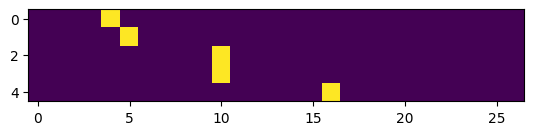

In [23]:
import matplotlib.pyplot as plt
plt.imshow(xenc)

In [26]:
# xenc: 5 x 27
# W: 27 x 27
# xenc @ W: 5 x 27
# b: 1 x 27

output = xenc@W + b
output.shape

torch.Size([5, 27])

In [36]:
counts = output.exp()
probs = counts / counts.sum(dim=1, keepdim=True)

probs[0,:]

tensor([0.0283, 0.0292, 0.0243, 0.0188, 0.0369, 0.0626, 0.0169, 0.0544, 0.0419,
        0.0219, 0.0340, 0.0302, 0.0352, 0.0257, 0.0523, 0.0300, 0.0549, 0.0249,
        0.0319, 0.0340, 0.0427, 0.0363, 0.0502, 0.0719, 0.0556, 0.0293, 0.0259],
       grad_fn=<SliceBackward0>)

In [35]:
F.softmax(output, dim=1)[0,:]

tensor([0.0283, 0.0292, 0.0243, 0.0188, 0.0369, 0.0626, 0.0169, 0.0544, 0.0419,
        0.0219, 0.0340, 0.0302, 0.0352, 0.0257, 0.0523, 0.0300, 0.0549, 0.0249,
        0.0319, 0.0340, 0.0427, 0.0363, 0.0502, 0.0719, 0.0556, 0.0293, 0.0259],
       grad_fn=<SliceBackward0>)

# Training loop ( - 01:47:00)

- get loss by fetching probs from normalized count matrix
    - .log().mean()
- backward pass (set gradients to None)
- learning rate of 50 for now
- run training loop over all xs for now